In [80]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [81]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")

In [82]:
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'

In [83]:
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [84]:
psi = 0

In [85]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [86]:
dx = 7.5 
dy = 7.5
dt = 1

In [87]:
depth, rows, cols = eta.shape
gridX, gridY = np.meshgrid(np.arange(1, cols+1), np.arange(1, rows+1))

# Centering and scaling
gridX = (gridX - np.mean(gridX)) * dx
gridY = (gridY - np.mean(gridY)) * dy

# ?? dont really know why youve to rescale the meshgrid of x and y

In [88]:
gridX

array([[-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       ...,
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5],
       [-247.5, -240. , -232.5, ...,  232.5,  240. ,  247.5]])

In [89]:
gridY

array([[-247.5, -247.5, -247.5, ..., -247.5, -247.5, -247.5],
       [-240. , -240. , -240. , ..., -240. , -240. , -240. ],
       [-232.5, -232.5, -232.5, ..., -232.5, -232.5, -232.5],
       ...,
       [ 232.5,  232.5,  232.5, ...,  232.5,  232.5,  232.5],
       [ 240. ,  240. ,  240. , ...,  240. ,  240. ,  240. ],
       [ 247.5,  247.5,  247.5, ...,  247.5,  247.5,  247.5]])

In [90]:
maxFrequency = 4.0 
# Approximate max  frequency to consider (converted to max wavenumber below) [rad/sec]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
# % wavenumber resolution of spectrum in each spatial window 
# (not strictly true if dx ~= dy, but value only needs to be approximate in practice)

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

In [91]:
dk

0.012503851357571316

In [92]:
wavenumbers = np.arange(3 * dk, 0.305, dk)
wavenumbers

# ?? dont know why the wavenumbers are like this 
# ?? can they be changed 

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [93]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

Ux_limits = [-1.0, 1.0]
# Ux current limits [m/s]

Uy_limits = [-1.0, 1.0]
# Uy current limts [m/s]

U_res = 0.1
# Current step size [m/s]

In [94]:
# The following OPTIONAL parameters involve post-processing of the Doppler shifts:
# SNR_filter: whether to use a signal-to-noise filter (false by default)
SNR_filter = 0;

SNR_threshold = np.sqrt(1)
# SNR_threshold: threshold signal-to-noise value for above filter (set to 2.0 by default)

In [95]:
# Peak_filter: whether to use a multiple peaks filter (false by default)
Peak_filter = 0;

# Peak_threshold: peak threshold of maximum value (0.5 by default)
Peak_threshold = 0.5;

# Outlier_filter: whether to use an outlier filter (quartile-based) (false by default)
Outlier_filter = 0;

# (optional): whether to include 2nd harmonic of the spectrum in the fit (false by default)
include2ndHarmonic = 0;

# (optional): whether to do the fit in log space (false by default)
logFlag = [];

# (optional) omegaWidthFun: function handle as a function of wavenumber i.e.
# @(k) f(k)...., specifying frequency width of the weighting function in
# frequency-angle space (constant wavenumber). Width is half-width 1/e^2
# point of a Gaussian function.
# omegaWidthFun = @(k) 0.4 + 0.1*k;
omegaWidthFun = lambda k: 0.05 + 0.0 * k


In [96]:
# Define the fluid & physical properties: depth, gravitational acceleration,
# surface tension coefficient
Properties = { 
    "h" : np.inf,
    "g" : 9.81,
    "T" : 0.072 / 1000
}

In [97]:
Uym, Uxm = np.meshgrid(np.arange(min(Uy_limits), max(Uy_limits) + U_res, U_res),
                       np.arange(min(Ux_limits), max(Ux_limits) + U_res, U_res))

In [98]:
Uym

array([[-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
         5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
       [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01,
        -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,
         5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00],
       [-1.00000000e+00, -9.00000000e-01, -8.00000000e-01,
        -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e

In [99]:
Uxm

array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
       [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
        -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
       [-8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e-01,
        -8.00000000e-01, -8.00000000e-01, -8.00000000e

In [100]:
# Assuming wavenumbers is already defined
num_wavenumbers = len(wavenumbers)

# Initialize Doppler shift variables
Ux = np.full(num_wavenumbers, np.nan)
Uy = np.full(num_wavenumbers, np.nan)

# ?? check if below are used 
UxC = np.full(num_wavenumbers, np.nan)
UyC = np.full(num_wavenumbers, np.nan)
UxLS = np.full(num_wavenumbers, np.nan)
UyLS = np.full(num_wavenumbers, np.nan)

In [101]:
SNR_max = np.full(num_wavenumbers, np.nan)

# Define some Functions

In [102]:
def generate_STCFIT_for_NSPP(STCFIT, wavenumbers=None, include2ndHarmonic=None, logFlag=None, omegaWidthFun=None,
                             SNR_filter=None, SNR_threshold=None, Peak_filter=None, Peak_threshold=None, Outlier_filter=None):

    # wavenumbers
    if wavenumbers is None:
        wavenumbers = np.arange(STCFIT['fit_param']['K_limits'][0], STCFIT['fit_param']['K_limits'][1] + 2 * np.pi / STCFIT['Windows']['sq_size_m'], 2 * np.pi / STCFIT['Windows']['sq_size_m'])

    # include2ndHarmonic
    if include2ndHarmonic is None:
        include2ndHarmonic = False

    # logFlag
    if logFlag is None:
        logFlag = False

    # omegaWidthFun
    if omegaWidthFun is None:
        dOmega = 2 * np.pi / ((STCFIT['Generic']['time_stamp'][-1] - STCFIT['Generic']['time_stamp'][0]) * 3600 * 24)
        omegaWidthFun = lambda k: dOmega + 0.1 * k

    # SNR_filter
    if SNR_filter is None:
        SNR_filter = False

    # SNR_threshold
    if SNR_threshold is None:
        SNR_threshold = 2.0

    # Peak_filter
    if Peak_filter is None:
        Peak_filter = False

    # Peak_threshold
    if Peak_threshold is None:
        Peak_threshold = 0.5

    # Outlier_filter
    if Outlier_filter is None:
        Outlier_filter = False

    STCFIT['NSPP_fit_param'] = {
        'wavenumbers': wavenumbers,
        'include2ndHarmonic': include2ndHarmonic,
        'logFlag': logFlag,
        'omegaWidthFun': omegaWidthFun,
        'SNR_filter': SNR_filter,
        'SNR_threshold': SNR_threshold,
        'Peak_filter': Peak_filter,
        'Peak_threshold': Peak_threshold,
        'Outlier_filter': Outlier_filter
    }

    return STCFIT

In [103]:
def retrieve_power_spectrum(IMG_3D, dx, dy, dt, K_limits=None, W_limits=None):
    """
    Retrieve 3D structure with power spectrum.

    Parameters:
        IMG_3D: 3D array with image sequence (X, Y, Time).
        dx: resolution in x (dim 1) [meters].
        dy: resolution in y (dim 2) [meters].
        dt: resolution in time (dim 3) [seconds].
        K_limits: [min, max] Wave-number interval to retrieve [rad/m].
        W_limits: [min, max] frequency interval to retrieve [rad/sec].

    Returns:
        Spectrum: Dictionary with power spectrum information.
    """

    if K_limits is None:
        K_limits = [-np.inf, np.inf]

    if W_limits is None:
        W_limits = [-np.inf, np.inf]

    # check limits
    if any(np.array(K_limits) < 0):
        print('retrieve_positive_spectrum: K_limits smaller than 0')

    if any(np.array(W_limits) < 0):
        print('retrieve_positive_spectrum: W_limits smaller than 0')

    # get Kx, Ky, and w axes
    Nt, Nx, Ny = IMG_3D.shape
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    Norm = dKx * dKy * dW

    # get power spectra
    Spectrum_raw = np.fft.fftshift(np.fft.fftn(IMG_3D) / np.prod(IMG_3D.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm) ** 2  # normalization not necessary

    # get index boundaries
    # K domain
    ind_x = np.abs(Kx) <= K_limits[1]
    ind_y = np.abs(Ky) <= K_limits[1]
    # W domain
    ind_w = np.logical_and(w >= W_limits[0], w <= W_limits[1])

    # create 3D structure
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w, Kx[ind_x], Ky[ind_y], indexing='ij')
    power_Spectrum_cut = power_Spectrum[:, ind_x, ind_y]

    # set to nan values out of K_limits
    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < K_limits[0]) | (K_3D > K_limits[1])] = np.nan

    # get original spectrum limits
    Kx_orig_limits = [Kx[0], Kx[-1]]
    Ky_orig_limits = [Ky[0], Ky[-1]]
    W_orig_limits = [w[0], w[-1]]

    # normalize spectra (sum(power_Spectrum_cut(:)) = 1)
    power_Spectrum_cut = power_Spectrum_cut / np.nansum(power_Spectrum_cut)

    # create output structure
    Spectrum = {
        'power_Spectrum': power_Spectrum_cut,
        'Kx_3D': Kx_3D,
        'Ky_3D': Ky_3D,
        'W_3D': W_3D,
        'dKx': dKx,
        'dKy': dKy,
        'dW': dW,
        'Kx_orig_limits': Kx_orig_limits,
        'Ky_orig_limits': Ky_orig_limits,
        'W_orig_limits': W_orig_limits
    }

    return Spectrum

In [104]:
from scipy.fftpack import fftn, fftshift

def retrieve_power_spectrum(IMG_3D, dx, dy, dt, K_limits=None, W_limits=None):
    # Set default values for K_limits and W_limits if not provided
    if K_limits is None:
        K_limits = [-np.inf, np.inf]
    if W_limits is None:
        W_limits = [-np.inf, np.inf]

    # Check limits
    if any(np.array(K_limits) < 0):
        print('retrieve_positive_spectrum: K_limits smaller than 0')
    if any(np.array(W_limits) < 0):
        print('retrieve_positive_spectrum: W_limits smaller than 0')

    # Get Kx, Ky, and w axes
    Nt, Nx, Ny = IMG_3D.shape
    Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1)
    Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1)
    w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1)

    dKx = Kx[1] - Kx[0]
    dKy = Ky[1] - Ky[0]
    dW = w[1] - w[0]
    Norm = dKx * dKy * dW

    # Get power spectra
    Spectrum_raw = fftshift(fftn(IMG_3D) / np.prod(IMG_3D.shape))
    power_Spectrum = np.abs(Spectrum_raw / Norm)**2

    # Get index boundaries
    ind_x = np.abs(Kx) <= K_limits[1]
    ind_y = np.abs(Ky) <= K_limits[1]
    ind_w = (w >= W_limits[0]) & (w <= W_limits[1])

    # Create 3D structure using meshgrid
    W_3D, Kx_3D, Ky_3D = np.meshgrid(w[ind_w], Kx[ind_x], Ky[ind_y], indexing='ij')

    # Use np.ix_ for boolean indexing to extract the desired values
    power_Spectrum_cut = power_Spectrum[np.ix_(ind_w, ind_x, ind_y)]

    # Set to NaN values outside K_limits
    K_3D = np.sqrt(Kx_3D**2 + Ky_3D**2)
    power_Spectrum_cut[(K_3D < K_limits[0]) | (K_3D > K_limits[1])] = np.nan

    # Get original spectrum limits
    Kx_orig_limits = [Kx[0], Kx[-1]]
    Ky_orig_limits = [Ky[0], Ky[-1]]
    W_orig_limits = [w[0], w[-1]]

    # Normalize spectra (sum(power_Spectrum_cut(:)) = 1)
    power_Spectrum_cut /= np.nansum(power_Spectrum_cut)

    # Create output structure
    Spectrum = {'power_Spectrum': power_Spectrum_cut,
                'Kx_3D': Kx_3D, 'Ky_3D': Ky_3D, 'W_3D': W_3D,
                'dKx': dKx, 'dKy': dKy, 'dW': dW,
                'Kx_orig_limits': Kx_orig_limits, 'Ky_orig_limits': Ky_orig_limits,
                'W_orig_limits': W_orig_limits}

    return Spectrum


In [105]:
import numpy as np

def find_peaks(A):
    peak_flag = np.zeros_like(A, dtype=bool)

    if np.ndim(A) == 1:  # 1D case
        peak_flag[0] = A[0] > A[1]
        peak_flag[-1] = A[-1] > A[-2]
        peak_flag[1:-1] = (A[1:-1] > A[:-2]) & (A[1:-1] > A[2:])
        return peak_flag

    else:  # General 2D case
        peak_flag[0, 0] = A[0, 0] > A[0, 1] and A[0, 0] > A[1, 0] and A[0, 0] > A[1, 1]
        peak_flag[0, -1] = A[0, -1] > A[0, -2] and A[0, -1] > A[1, -1] and A[0, -1] > A[1, -2]
        peak_flag[-1, -1] = A[-1, -1] > A[-1, -2] and A[-1, -1] > A[-2, -1] and A[-1, -1] > A[-2, -2]
        peak_flag[-1, 0] = A[-1, 0] > A[-2, 0] and A[-1, 0] > A[-2, 1] and A[-1, 0] > A[-1, 1]

        # Edges (5 nearest neighbors)
        peak_flag[0, 1:-1] = (A[0, 1:-1] > A[0, :-2]) & (A[0, 1:-1] > A[0, 2:]) & \
                            (A[0, 1:-1] > A[1, :-2]) & (A[0, 1:-1] > A[1, 1:-1]) & (A[0, 1:-1] > A[1, 2:])
        peak_flag[-1, 1:-1] = (A[-1, 1:-1] > A[-1, :-2]) & (A[-1, 1:-1] > A[-1, 2:]) & \
                             (A[-1, 1:-1] > A[-2, :-2]) & (A[-1, 1:-1] > A[-2, 1:-1]) & (A[-1, 1:-1] > A[-2, 2:])
        peak_flag[1:-1, 0] = (A[1:-1, 0] > A[:-2, 0]) & (A[1:-1, 0] > A[2:, 0]) & \
                             (A[1:-1, 0] > A[:-2, 1]) & (A[1:-1, 0] > A[1:-1, 1]) & (A[1:-1, 0] > A[2:, 1])
        peak_flag[1:-1, -1] = (A[1:-1, -1] > A[:-2, -1]) & (A[1:-1, -1] > A[2:, -1]) & \
                              (A[1:-1, -1] > A[:-2, -2]) & (A[1:-1, -1] > A[1:-1, -2]) & (A[1:-1, -1] > A[2:, -2])

        # Interior region (8 nearest neighbors)
        peak_flag[1:-1, 1:-1] = (A[1:-1, 1:-1] > A[:-2, :-2]) & \
                                (A[1:-1, 1:-1] > A[1:-1, :-2]) & \
                                (A[1:-1, 1:-1] > A[2:, :-2]) & \
                                (A[1:-1, 1:-1] > A[2:, 1:-1]) & \
                                (A[1:-1, 1:-1] > A[2:, 2:]) & \
                                (A[1:-1, 1:-1] > A[1:-1, 2:]) & \
                                (A[1:-1, 1:-1] > A[:-2, 2:]) & \
                                (A[1:-1, 1:-1] > A[:-2, 1:-1])

        return peak_flag

In [112]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, verboseFig=False):
    if not verboseFig:
        verboseFig = 0

    if 'include2ndHarmonic' not in fit_param:
        fit_param['include2ndHarmonic'] = 0

    if 'logFlag' not in fit_param:
        fit_param['logFlag'] = 0

    if 'SNR_filter' not in fit_param:
        fit_param['SNR_filter'] = 0

    if 'SNR_threshold' not in fit_param:
        fit_param['SNR_threshold'] = 2.0

    if 'Peak_filter' not in fit_param:
        fit_param['Peak_filter'] = 0

    if 'Peak_threshold' not in fit_param:
        fit_param['Peak_threshold'] = 0.5

    if 'Outlier_filter' not in fit_param:
        fit_param['Outlier_filter'] = 0

    out_fit = {'wavenumbers': fit_param['wavenumbers'],
               'Ux': np.zeros(len([fit_param['wavenumbers']])),
               'Uy': np.zeros(len([fit_param['wavenumbers']])),
               'SNR_max': np.zeros(len([fit_param['wavenumbers']])),
               'Ux_2D': fit_param['Ux_2D'],
               'Uy_2D': fit_param['Uy_2D'],
               'verbose': []}

    h = Properties['h']
    g = Properties['g']
    T = Properties['T']
    omegaWidthFun = fit_param['omegaWidthFun']
    wavenumbers = fit_param['wavenumbers']

    for jj in range(len([fit_param['wavenumbers']])):
        P = {'h': h, 'g': g, 'T': T,
             'omegaWidth': omegaWidthFun(wavenumbers),
             'kWidth': fit_param['kWidth'],
             'logFlag': fit_param['logFlag'],
             'include2ndHarmonic': fit_param['include2ndHarmonic']}

        snrG = np.zeros(fit_param['Ux_2D'].shape)

        for i in range(fit_param['Ux_2D'].shape[0]):
            for j in range(fit_param['Ux_2D'].shape[1]):
                snr_ij, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, fit_param['Ux_2D'][i, j], fit_param['Uy_2D'][i, j])
                snrG[i, j] = snr_ij

        im = np.argmax(snrG)

        if np.ndim(fit_param['Ux_2D']) == 1:
            cDoppGuess = fit_param['Ux_2D'][im]
        else:
            cDoppGuess = [fit_param['Ux_2D'].flat[im], fit_param['Uy_2D'].flat[im]]

        options = {'disp': False}  # Turn off display output
        Ufit = minimize(lambda U: 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0] if np.ndim(U) > 1 else 1 - nsp_doppler_shift_extraction(Spectrum, P, fit_param['wavenumbers'], U[0], U[1])[0], 
                        cDoppGuess, options=options)

        if len(cDoppGuess) > 1:
            Ufit = Ufit.x
        else:
            Ufit = [Ufit.x[0], 0]

        SNR_fit, _, _ = nsp_doppler_shift_extraction(Spectrum, P, wavenumbers, Ufit[0], Ufit[1])

        out_fit['Ux'][jj] = Ufit[0]
        out_fit['Uy'][jj] = Ufit[1]
        out_fit['SNR_max'][jj] = SNR_fit

        verbose = {'k': fit_param['wavenumbers'], 'SNR_2D': snrG, 'Peaks_2D': find_peaks(snrG)}
        out_fit['verbose'].append(verbose)

    # Post-processing
    out_fit['Ux_filt'] = out_fit['Ux'].copy()
    out_fit['Uy_filt'] = out_fit['Uy'].copy()
    out_fit['SNR_max'] = out_fit['SNR_max'].copy()

    if fit_param['SNR_filter']:
        SNR_inds = out_fit['SNR_max'] > fit_param['SNR_threshold']
        out_fit['Ux_filt'][~SNR_inds] = np.nan
        out_fit['Uy_filt'][~SNR_inds] = np.nan

    if fit_param['Peak_filter']:
        indsMultPeaks = peak_filter(out_fit['verbose'], fit_param['Peak_threshold'])
        out_fit['Ux_filt'][indsMultPeaks] = np.nan
        out_fit['Uy_filt'][indsMultPeaks] = np.nan

    if fit_param['Outlier_filter']:
        indsX_keep = quartile_filter(out_fit['wavenumbers'], out_fit['Ux_filt'])
        indsY_keep = quartile_filter(out_fit['wavenumbers'], out_fit['Uy_filt'])
        out_fit['Ux_filt'][~indsX_keep] = np.nan
        out_fit['Uy_filt'][~indsY_keep] = np.nan

    return out_fit


# Peak filter. Returns indices where there are multiple peaks in the SNR_2D field exceeding a threshold value.
def peak_filter(S, peak_thresh):
    inds_multiple_peaks = np.zeros(len(S), dtype=bool)

    for i in range(len(S)):
        peak_vals = S[i]['SNR_2D'][S[i]['Peaks_2D']]
        inds_multiple_peaks[i] = np.sum(peak_vals / np.max(peak_vals) > peak_thresh) > 1

    return inds_multiple_peaks


# Filter based on quartiles
def quartile_filter(x, y):
    inds_nan = np.isnan(y)

    x = x[~inds_nan]
    y = y[~inds_nan]

    pct = np.polyfit(x, y, 1)
    delCtil = y - np.polyval(pct, x)
    delCtil_srt = np.sort(delCtil)

    Q1 = np.median(delCtil_srt[:round(len(delCtil_srt) / 2)])
    Q3 = np.median(delCtil_srt[round(len(delCtil_srt) / 2):])
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    inds_keep = np.logical_and(delCtil > lower_fence, delCtil < upper_fence)

    inds_outlier = np.ones(inds_nan.shape, dtype=bool)
    inds_outlier[~inds_nan] = inds_keep

    return inds_outlier


In [117]:
def nsp_doppler_shift_extraction(Spectrum, params, kval, U, V):
    # Define wave dispersion relation.
    omegaFun = lambda kx, ky: np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h'])) + U*kx + V*ky

    # Frequency width of weighting function (1/e^2 halfwidth)
    a = params['omegaWidth']

    if 'logFlag' not in params:
        params['logFlag'] = 0

    if 'include2ndHarmonic' not in params:
        params['include2ndHarmonic'] = 0

    if 'kWidth' in params:
        a_k = params['kWidth']
    else:
        a_k = max(Spectrum['dKx'], Spectrum['dKy']) * 2

    inds = ~np.isnan(Spectrum['power_Spectrum'])

    P_k = np.sqrt(Spectrum['power_Spectrum'][inds])
    KX = Spectrum['Kx_3D'][inds]
    KY = Spectrum['Ky_3D'][inds]
    W = Spectrum['W_3D'][inds]

    if params['include2ndHarmonic']:
        inds2 = ~np.isnan(Spectrum['power_Spectrum2'])
        P_k2 = np.sqrt(Spectrum['power_Spectrum2'][inds2])
        KX2 = Spectrum['Kx_3D2'][inds2]
        KY2 = Spectrum['Ky_3D2'][inds2]
        W2 = Spectrum['W_3D2'][inds2]
        omegaFun2 = lambda kx, ky: np.sqrt(2) * np.sqrt((params['g']*np.sqrt(kx**2 + ky**2) + params['T']*np.sqrt(kx**2 + ky**2)**3) * np.tanh(np.sqrt(kx**2 + ky**2) * params['h']) + U*kx + V*ky)
    else:
        P_k2 = 0

    if params['logFlag']:
        P_k = np.log(P_k)
        P_k = P_k - np.min(P_k)

        if params['include2ndHarmonic']:
            P_k2 = np.log(P_k2)
            P_k2 = P_k2 - np.min(P_k2)

    K = np.sqrt(KX**2 + KY**2)
    order = 2

    if not np.isnan(kval):
        P_k = P_k * np.exp(-2*((K-kval)/a_k)**order)

    # Define weighting function G
    G1 = np.exp(-2*((W - omegaFun(KX, KY))/a)**order)
    G2 = np.exp(-2*((W + omegaFun(-KX, -KY))/a)**order)

    G = G1 + G2

    if params['include2ndHarmonic']:
        G1_2 = np.exp(-2*((W2 - omegaFun2(KX2, KY2))/a)**order)
        G2_2 = np.exp(-2*((W2 + omegaFun2(-KX2, -KY2))/a)**order)

        G_2 = G1_2 + G2_2

        P_k2[~np.isfinite(P_k2)] = 0

        signal_2 = np.sum(P_k2*G_2)/np.sum(G_2)
        noise_2 = np.sum(P_k2*(1-G_2))/np.sum(1-G_2)
    else:
        signal_2 = 0
        noise_2 = 0

    P_k[~np.isfinite(P_k)] = 0
    InP = P_k * G

    signal_1 = np.sum(InP)/np.sum(G)
    noise_1 = np.sum(P_k*(1-G))/np.sum(1-G)
    SNR = (signal_1 + signal_2)/(noise_1 + noise_2)

    return SNR, P_k, G


# Doppler Shift Loop to get Spectrum

## One Iteration

In [118]:
wavenumberLimits = wavenumbers[14] + kW * np.array([-1, 1])
# wavenumber limits for masking the spectrum [min max], rad/sec

# Assuming STCFIT is a dictionary and fileName, wavenumbers, include2ndHarmonic, logFlag, omegaWidthFun,
# SNR_filter, SNR_threshold, Peak_filter, Peak_threshold, Outlier_filter are defined

STCFIT = {'Name': [fileName]}
STCFIT = generate_STCFIT_for_NSPP(STCFIT, wavenumbers[14], include2ndHarmonic, logFlag,
                                omegaWidthFun, SNR_filter, SNR_threshold, Peak_filter, Peak_threshold, Outlier_filter)
    
fit_param = STCFIT['NSPP_fit_param']
fit_param['kWidth'] = 4 * kW
fit_param['Ux_2D'] = Uxm
fit_param['Uy_2D'] = Uym
    
# Now extract the Doppler shifts 
Spectrum = retrieve_power_spectrum(
    eta,
    dx,
    dy,
    dt,
    wavenumberLimits,
    frequencyLimits
)

if fit_param['include2ndHarmonic']:
    Spectrum2 = retrieve_power_spectrum(
        eta,
        dx,
        dy,
        dt,
        2 * wavenumberLimits,
        frequencyLimits
    )

    Spectrum['power_Spectrum2'] = Spectrum2['power_Spectrum']
    Spectrum['Kx_3D2'] = Spectrum2['Kx_3D']
    Spectrum['Ky_3D2'] = Spectrum2['Ky_3D']
    Spectrum['W_3D2'] = Spectrum2['W_3D']

out_DS = get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, 1)

In [119]:
out_DS

{'wavenumbers': 0.21256547307871237,
 'Ux': array([-0.50891388]),
 'Uy': array([-0.00209782]),
 'SNR_max': array([16.25928799]),
 'Ux_2D': array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
        [-8.00000000

# Loops and plots it

Processing wavenumbers: 100%|██████████| 22/22 [06:30<00:00, 17.73s/it]


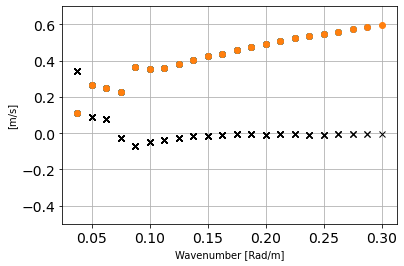

In [122]:
from tqdm import tqdm

DSV = [None] * len(wavenumbers)  # Initialize DSV list
Ux = [None] * len(wavenumbers)  # Initialize Ux list
Uy = [None] * len(wavenumbers)  # Initialize Uy list
SNR_max = np.zeros_like(wavenumbers)  # Initialize SNR_max array

# Add TQDM progress bar
for jj in tqdm(range(len(wavenumbers)), desc="Processing wavenumbers"):
    wavenumberLimits = wavenumbers[jj] + kW * np.array([-1, 1])
    # wavenumber limits for masking the spectrum [min max], rad/sec

    # Assuming STCFIT is a dictionary and fileName, wavenumbers, include2ndHarmonic, logFlag, omegaWidthFun,
    # SNR_filter, SNR_threshold, Peak_filter, Peak_threshold, Outlier_filter are defined

    STCFIT = {'Name': [fileName]}
    STCFIT = generate_STCFIT_for_NSPP(STCFIT, wavenumbers[jj], include2ndHarmonic, logFlag,
                                  omegaWidthFun, SNR_filter, SNR_threshold, Peak_filter, Peak_threshold, Outlier_filter)
    
    fit_param = STCFIT['NSPP_fit_param']
    fit_param['kWidth'] = 4 * kW
    fit_param['Ux_2D'] = Uxm
    fit_param['Uy_2D'] = Uym
    
    # Now extract the Doppler shifts 
    Spectrum = retrieve_power_spectrum(
        eta,
        dx,
        dy,
        dt,
        wavenumberLimits,
        frequencyLimits
    )

    if fit_param['include2ndHarmonic']:
        Spectrum2 = retrieve_power_spectrum(
            eta,
            dx,
            dy,
            dt,
            2 * wavenumberLimits,
            frequencyLimits
        )

        Spectrum['power_Spectrum2'] = Spectrum2['power_Spectrum']
        Spectrum['Kx_3D2'] = Spectrum2['Kx_3D']
        Spectrum['Ky_3D2'] = Spectrum2['Ky_3D']
        Spectrum['W_3D2'] = Spectrum2['W_3D']

    out_DS = get_doppler_shift_velocities_nsp(Spectrum, fit_param, Properties, 1)

    DSV[jj] = out_DS
    Ux[jj] = -float(out_DS['Ux_filt'])  # Ensure Ux is a scalar
    Uy[jj] = float(out_DS['Uy_filt'])  # Ensure Uy is a scalar
    SNR_max[jj] = out_DS['SNR_max']
    
    plt.figure(10)
    plt.plot(wavenumbers, Ux, 'o', label=r'$\tilde{c}_x$')
    plt.plot(wavenumbers, Uy, 'xk', label=r'$\tilde{c}_y$')
    plt.xlabel('Wavenumber [Rad/m]')
    plt.ylabel('[m/s]')
    plt.ylim(1 * np.array([-0.5, 0.7]))
    # plt.legend(loc='lower right', fontsize=12)
    plt.gca().tick_params(labelsize=14)
    plt.draw()
    plt.grid(True)
    
plt.show()

In [64]:
out_DS

{'wavenumbers': 0.3000924325817116,
 'Ux': array([-2.03279718]),
 'Uy': array([0.011218]),
 'SNR_max': array([15.62031596]),
 'Ux_2D': array([[-1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00,
         -1.00000000e+00, -1.00000000e+00, -1.00000000e+00],
        [-9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01,
         -9.00000000e-01, -9.00000000e-01, -9.00000000e-01],
        [-8.00000000e-01